# Use GANs to create art - will you be the next Monet?

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf



from tensorflow.keras import layers ,Model
from tensorflow.keras.layers import Dense, Flatten,Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam



In [ ]:

try:
  
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:  
    print("No TPU found, using default strategy.")
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            strategy = tf.distribute.MirroredStrategy()
            print("Using MirroredStrategy for GPU distribution.")
        except RuntimeError as e:
            print(e)
    else:
        strategy = tf.distribute.get_strategy()
        print("No GPU found, using default strategy.")

print('Number of replicas:', strategy.num_replicas_in_sync)



No TPU found, using default strategy.
Using MirroredStrategy for GPU distribution.
Number of replicas: 2


TFRecord is a binary file format used by TensorFlow for efficient storage of large data sets. Instead of storing data directly in a human-readable format, it serializes the data into a compact, continuous format, which makes TFRecord files ideal for use in input pipelines, especially when large data sets need to be processed.

A TFRecord file consists of a series of records, each of which is a string, with the following internal structure:

Length Prefix: A VARint-encoded integer indicating the byte length of the next part of the data.
Data: Actual data, which can be any byte stream.
CRC-32C Checksum (CRC-32C Checksum) : Another Varint-encoded integer containing the CRC-32C checksum, used to verify that parts of the data were corrupted during transmission or storage.

### Load Data
The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos.

* monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
* monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
* photo_jpg - 7028 photos sized 256x256 in JPEG format
* photo_tfrec - 7028 photos sized 256x256 in TFRecord format

In [39]:

# Defining the directories for the image locations

# path='Datasets'
path='/kaggle/input/gan-getting-started'
monet_jpegs = path+"/monet_jpg"
photos_jpegs = path+"/photo_jpg"
monet_tfrec = path+"/monet_tfrec"
photos_tfrec = path+"/photo_tfrec"
MONET_FILENAMES = tf.io.gfile.glob(str(monet_tfrec+'/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(photos_tfrec + '/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


Load TFRecord to Image

In [ ]:
IMAGE_SIZE = [256, 256]
BATCH_SIZE = 2
EPOCHS =30
def tfrec2image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = tfrec2image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset


monet_data = load_dataset(MONET_FILENAMES)
for batch_monet_images in monet_data.take(1):  
    print("Shape of a batch of images:", batch_monet_images.shape)
photo_data = load_dataset(PHOTO_FILENAMES)
for batch_photo_images in photo_data.take(1):  
    print("Shape of a batch of images:", batch_photo_images.shape)
    
    


Shape of a batch of images: (2, 256, 256, 3)
Shape of a batch of images: (2, 256, 256, 3)


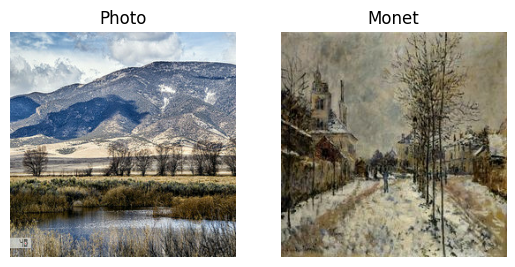

In [41]:
plt.subplot(1,2,1)
plt.title('Photo')
plt.imshow(batch_photo_images[0] * 0.5 + 0.5)
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Monet')
plt.imshow(batch_monet_images[0] * 0.5 + 0.5)
plt.axis('off')

plt.show()

In [42]:

class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer="ones",
            trainable=True
        )
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer="zeros",
            trainable=True
        )

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        return self.scale * (inputs - mean) / tf.sqrt(variance + self.epsilon) + self.offset

# filter-The number of filters in the Conv2D layer is the number of output feature maps
# size -Convolution kernel size
def Cov2d(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        instance_norm_layer = InstanceNormalization()
        result.add(instance_norm_layer)
    result.add(layers.LeakyReLU())
    return result


def deCov2d(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    instance_norm_layer = InstanceNormalization()
    result.add(instance_norm_layer)
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

The process of down-sampling and up-sampling enables deep learning models to extract and recover features efficiently, while reducing computational complexity and enhancing the model's ability to process features at different scales.

Downsampling:
Each layer continues to use a 4x4 convolution kernel with a step size of 2, gradually reducing the space size and increasing the number of channels until the final layer reaches the maximum number of channels of 512

In [43]:
def Generator():
    inputs  = layers.Input(shape=[256,256,3])
    
    Downsampling =[
        Cov2d(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        Cov2d(128, 4), # (bs, 64, 64, 128)
        Cov2d(256, 4), # (bs, 32, 32, 256)
        Cov2d(512, 4), # (bs, 16, 16, 512)
        Cov2d(512, 4), # (bs, 8, 8, 512)
        Cov2d(512, 4), # (bs, 4, 4, 512)
        Cov2d(512, 4), # (bs, 2, 2, 512)
        Cov2d(512, 4), # (bs, 1, 1, 512)
    ]
    
    Upsampling = [
        deCov2d(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        deCov2d(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        deCov2d(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        deCov2d(512, 4), # (bs, 16, 16, 1024)
        deCov2d(256, 4), # (bs, 32, 32, 512)
        deCov2d(128, 4), # (bs, 64, 64, 256)
        deCov2d(64, 4), # (bs, 128, 128, 128)
    ]
    
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')  # (bs, 256, 256, 3)

    x = inputs

    skips = []
    for down in Downsampling:
        x = down(x)
        skips.append(x)
    #The last element has been removed because it was already used during the initial decoder_stack phase
    skips = reversed(skips[:-1]) 

    for up, skip in zip(Upsampling, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inputs = layers.Input(shape=[256, 256, 3])  # 输入图像尺寸为 256x256，3 个通道（RGB）

  
    encoder_stack = [
        Cov2d(64, 4, apply_instancenorm=False),  # (bs, 128, 128, 64)
        Cov2d(128, 4),  # (bs, 64, 64, 128)
        Cov2d(256, 4),  # (bs, 32, 32, 256)
        Cov2d(512, 4),  # (bs, 16, 16, 512)
    ]

    
    x = inputs

  
    for down in encoder_stack:
        x = down(x)

    # zero_pad1 = layers.ZeroPadding2D()(x)  #  (bs, 34, 34, 256)
    # conv = layers.Conv2D(512, 4, strides=1,
    #                      kernel_initializer=initializer,
    #                      use_bias=False)(zero_pad1)  # 卷 (bs, 31, 31, 512)
    # instance_norm_layer = InstanceNormalization()
    # norm1 = instance_norm_layer(conv)  
    # leaky_relu = layers.LeakyReLU()(norm1) 

    # zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)
    # last = layers.Conv2D(1, 4, strides=1,
    #                      kernel_initializer=initializer)(zero_pad2)  #  (bs, 30, 30, 1)
    
    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(x)#(bs, 13, 13, 1)
    return Model(inputs=inputs, outputs=last)  

In [45]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

View feature extraction and dimensionality reduction

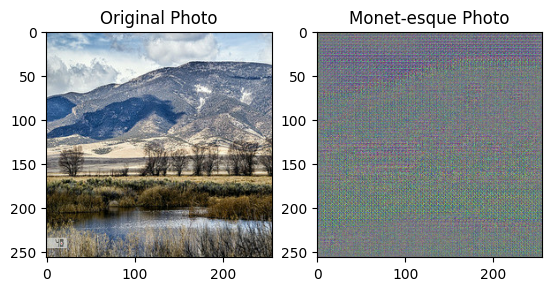

In [46]:
to_monet = monet_generator(batch_photo_images)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(batch_photo_images[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

CycleGAN model

By learning the mapping relationship between two different domains, CycleGAN can transform image styles without using paired training data.

In [47]:
# Setting up the new GAN model
class CycleGAN(Model):
    def __init__(self,monet_generator,photo_generator,monet_discriminator,photo_discriminator,lambda_cycle=10,):
        super(CycleGAN, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.d_loss_arr = []
        self.g_loss_arr = []
        
    def compile(self,m_gen_optimizer,p_gen_optimizer,m_disc_optimizer,p_disc_optimizer,gen_loss_fn,disc_loss_fn,cycle_loss_fn,identity_loss_fn):
        super(CycleGAN, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        # print(batch_data)
        real_monet, real_photo = batch_data
        print("Real Monet shape:", real_monet.shape)
        print("Real Photo shape:", real_photo.shape)
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Using discriminator to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        self.g_loss_arr.append(total_monet_gen_loss + total_photo_gen_loss)
        self.d_loss_arr.append(monet_disc_loss + photo_disc_loss)
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [48]:
with strategy.scope():
    def discriminator_loss(real, generated):
        #The output of the real image should be close to 1 ( considered real)
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        #The output of the generated image should be close to 0 ( considered fake)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    def generator_loss(generated):
        #The generator wants to produce images that the discriminator thinks are real ( the output is close to 1)
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    # LAMBDA-  The weight coefficient of the cyclic consistency loss, used to control the importance of this loss relative to other losses
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        return LAMBDA * tf.reduce_mean(tf.abs(real_image - cycled_image))
    
    def identity_loss(real_image, same_image, LAMBDA):
        return LAMBDA * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))
    

In [49]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [50]:
with strategy.scope():
    cycle_gan_model = CycleGAN(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [ ]:
with strategy.scope():
    history = cycle_gan_model.fit(tf.data.Dataset.zip((monet_data, photo_data)),
                        steps_per_epoch=(300//BATCH_SIZE),
                        epochs=EPOCHS,
                        verbose=2).history

Epoch 1/30
Real Monet shape: (None, 256, 256, 3)
Real Photo shape: (None, 256, 256, 3)
Real Monet shape: (None, 256, 256, 3)
Real Photo shape: (None, 256, 256, 3)
Real Monet shape: (None, 256, 256, 3)
Real Photo shape: (None, 256, 256, 3)
Real Monet shape: (None, 256, 256, 3)
Real Photo shape: (None, 256, 256, 3)


2024-12-12 04:06:53.650813: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_760/cond/StatefulPartitionedCall/functional_108_1/sequential_84_1/dropout_12_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


150/150 - 195s - 1s/step - monet_disc_loss: 0.7569 - monet_gen_loss: 4.5087 - photo_disc_loss: 0.8334 - photo_gen_loss: 5.1026
Epoch 2/30
150/150 - 0s - 138us/step - monet_disc_loss: 0.7569 - monet_gen_loss: 4.5087 - photo_disc_loss: 0.8334 - photo_gen_loss: 5.1026
Epoch 3/30


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


150/150 - 81s - 538ms/step - monet_disc_loss: 0.6855 - monet_gen_loss: 3.9967 - photo_disc_loss: 0.7665 - photo_gen_loss: 4.6432
Epoch 4/30
150/150 - 0s - 83us/step - monet_disc_loss: 0.6855 - monet_gen_loss: 3.9967 - photo_disc_loss: 0.7665 - photo_gen_loss: 4.6432
Epoch 5/30


In [ ]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_data.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [ ]:
import shutil
import os
 
if __name__ == '__main__':
    path = '/kaggle/working/images'
    if os.path.exists(path):
        shutil.rmtree(path)
        print('Deletion complete')
    else:
        print('Originally null')

In [ ]:
import PIL
import os
os.makedirs('images', exist_ok=True)

In [ ]:
i = 1
for img in photo_data:
    for batch in range(BATCH_SIZE):
        img_g=img[batch:batch+1]
        # print(img_g.shape)
        prediction = monet_generator(img_g, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        im = PIL.Image.fromarray(prediction)
        im.save("images/" + str(i) + ".jpg")
        i += 1
  


print(i)

In [ ]:
import zipfile
import os

def zip_directory(folder_path, output_zip):
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname)

zip_directory('/kaggle/working/images', '/kaggle/working/images.zip')

In [ ]:
print('completion of task')